In this notebook, we will explore the influence of r/WallStreeBets on the stock market. In 2021, uprecedented spikes in stocks like GameStop and AMC occured, with credit attributed to the small community of r/WallStreetBets. Their collective efforts and motivation turned the investment world upside down temporarily, resulting in many news headlines, a super bowl ad, and a vision for future of investing for the little guy.

For this experiment, we'll look at the most frequently mentioned stocks on r/WallStreetBets and look for any correlation with their stock performance.

Prerequisites:

1. Access to Beneath API for reddit data: https://about.beneath.dev/
2. Access to Alpha Vantage API for stock data: https://www.alphavantage.co/

There are two aspects of accumulating data:

1. Scraping r/WallStreetBets posts for stocks that have the hightest mention count
2. Aggregating the historical stock data for each of the r/WallStreetBets stocks



In [80]:
import calendar
import time
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import calendar
import beneath as b
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

rand_seed=42
np.random.seed(rand_seed)

In [2]:
# retrieve API keys
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line, with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)
        
filename = 'apikey'
key = get_file_contents(filename)

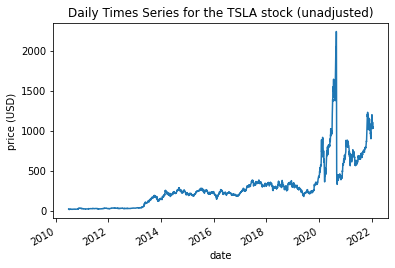

In [126]:
# alpha_vantage is a nice API for collecting historic stock data 
# we'll take a peek at the historic Amazon (AMZN) price


ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='TSLA', outputsize='full')

data['4. close'].plot()
plt.ylabel('price (USD)')
plt.title('Daily Times Series for the TSLA stock (unadjusted)')
plt.savefig('fig/alpha-vantage-TSLA-price.png')
plt.show()

In [4]:
# Alpha Vantage API does not play nicely with these symbols, so we ignore them
blacklist = [
    'NAKD',
    'XELA',
    'AGC'
]

months =  { 
    "January":   1,
    "February":  2,
    "March":     3,
    "April":     4,
    "May":       5,
    "June":      6,
    "July":      7,
    "August":    8,
    "September": 9,
    "October":  10,
    "November": 11,
    "December": 12
}

def get_month_id(m):
    return months[m]

def encode_months(timestamps):
    # Column will be of type str if the dataframe is loaded from csv
    if type(timestamps[0]) == str:
        return timestamps.apply(lambda x: get_month_id(datetime.datetime.fromisoformat(x).strftime("%B")))
    # Column will be of type datetime if the dataframe is queried from beneath API
    else:
        return timestamps.apply(lambda x: get_month_id(x.month_name()))
    
def get_days_in_months(month):
    month_val = months[month]
    return calendar.monthrange(2021, month_val)[1]

def get_month_avg(month, df, year='2021', mtd=False):
    month_sum = 0
    if mtd:
        days_in_month = datetime.datetime.today().day # if the month is not finished, we get month-to-date days
    else:
        days_in_month = get_days_in_months(month)
    
    for day in range(1, days_in_month+1):
        try:
            daily_high = float(df.loc[f'{year}-{months[month]}-{day}']['2. high'])
            daily_low = float(df.loc[f'{year}-{months[month]}-{day}']['3. low'])
            daily_avg = (daily_high + daily_low) / 2
            month_sum += daily_avg
        except TypeError:
            days_in_month-=1 # The market was closed on this date (no data points), so we take 1 day off days_in_month
            
            if days_in_month == 0: # Possible if a stock has its IPO mid-year, and therefore will have no data for some months
                return 0 
            
            continue
        
#     print(f'{month} average ({month_sum}/{days_in_month}): {month_sum / days_in_month}')
    
    return month_sum / days_in_month # month average for the stock

def get_pct_change(previous, current):
    if current == previous:
        return 0
    try:
        return ((current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return float(0) # This would mathematically be infinity, but in context it means a stock recently IPO'd

def get_pct_increases(df):
    highs = []
    pct_changes = []
    
    for m in months.keys():
        highs.append(get_month_avg(m, df))
    highs.append(get_month_avg('January', df, year='2022', mtd=True)) # January 2022 (TODO: mtd=False starting in Feb)
    
    for i in range(1,len(highs)):
        curr_month_avg = highs[i]
        prev_month_avg = highs[i-1]
        
        pct_changes.append(get_pct_change(prev_month_avg, curr_month_avg))
    
    return pct_changes

def get_stock_pct_changes(stock):
    print(stock)
    df, _ = ts.get_daily(symbol=stock, outputsize='full')
    
    
    return get_pct_increases(df)

def get_top_N_stocks(df, N=10):
    # These symbols (stocks) are the top N most frequently mentioned along with post count
    top_N_stonks = dict(df.symbol.value_counts()[:N])

    # Drop rows from dataframe df if the symbol is not in top_stonks
    symbol_names_N = list(top_N_stonks.keys())
    df_top_N = df[df.symbol.isin(symbol_names_N)].sort_values(by=['symbol', 'month'])
    df_top_N = df_top_N[df_top_N['month'] > 2]
    
    return top_N_stonks, df_top_N

def get_stock_pcts_and_mentions(top_N, df_top_N):
    wsb_data = {}
    percentages = []
    
    # For every symbol in the top N stocks, get the monthly average stock prices and their monthy r/WallStreeBets mention count
    for symbol in list(reversed(list(top_N.keys()))):
        
        if symbol in blacklist:
            # Retrieving data for companies that had their IPO this year is buggy.
            print(f'{symbol} recently had their IPO. Skipping.')
            continue
        
        stock_data = {}
        stock_data['pcts'] = get_stock_pct_changes(symbol) # API call happens here
        
        stock_mentions = []
        stock = df_top_N.loc[df_top_N.symbol == symbol]
        
        for month in months.values():
            stock_mentions.append(len(stock.loc[df_top_N['month'] == month]))
        
        stock_data['mentions'] = stock_mentions

        wsb_data[symbol] = stock_data
        
        time.sleep(15) # Free tier API calls are limited to 5 per minute
    
    return wsb_data

# Section 1: Scraping Data from Reddit

In [5]:
# This filter will get post data for 2021 plus January 2022
_filter = '{ "num_unique_symbols_title": "1", "timestamp": { "_gte": "2021-01-01", "_lt": "2022-01-31" } }'

In [6]:
# # beneath client for accessing table, uncomment to access the API (be careful; free tier is metered)

# client = b.Client()
# table = await client.find_table("examples/wallstreetbets-analytics/r-wallstreetbets-posts-stock-mentions")
# # cursor = await table.primary_instance.query_index(filter=_filter)
# cursor = await table.primary_instance.query_index()
# record = await cursor.read_all(to_dataframe=True)
# # record.to_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')

In [7]:
record = pd.read_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')
month_encoded = encode_months(record['timestamp'])
df = record.drop(columns=['@meta.timestamp', 'post_id','author','timestamp','Unnamed: 0'])
df.insert(loc=0, column='month', value=month_encoded)

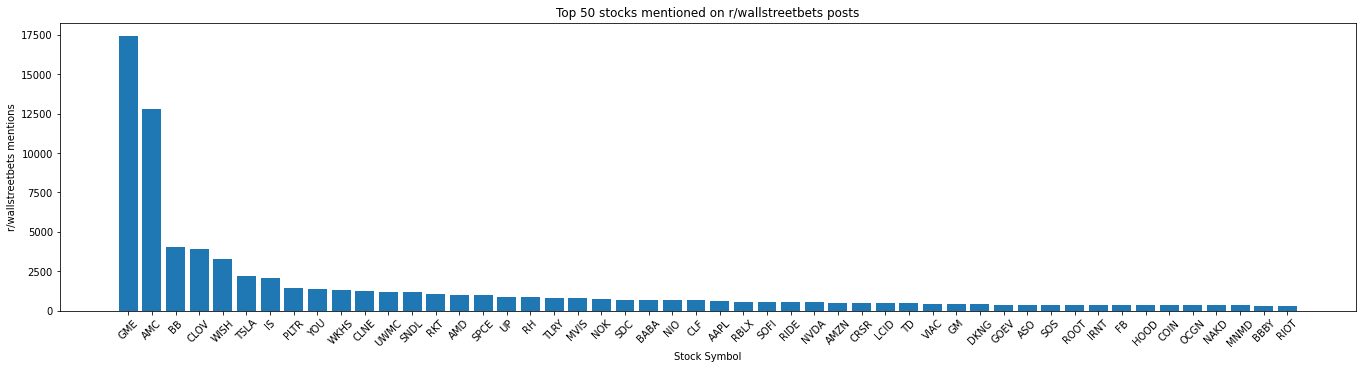

In [125]:
top_N_stonks, df_top_N = get_top_N_stocks(df, N=50)

# We can look at the top 50 stocks mentioned on r/wallstreetbets
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
symbols = list(top_N_stonks.keys())
posts = list(top_N_stonks.values())
ax.bar(symbols, posts)
plt.xlabel("Stock Symbol")
plt.ylabel("r/wallstreetbets mentions")
plt.title('Top 50 stocks mentioned on r/wallstreetbets posts')
plt.xticks(rotation = 45)
plt.savefig('fig/wsb-top50-mentions.png')
plt.show()

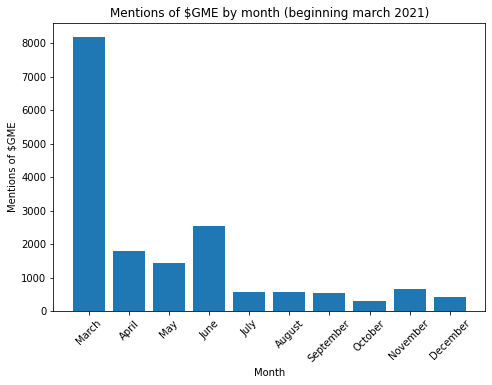

In [115]:
# Let's take a look at mentions of GameStop (GME) by month from March 2021 to Dec 2021
gme_mentions = []

gme = df_top_N.loc[df_top_N['symbol'] == 'GME']
for month in months.values():
    gme_mentions.append(len(gme.loc[df_top_N['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
gme_mentions = gme_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], gme_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $GME")
plt.title('Mentions of $GME by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.savefig('fig/wsb-GME-mentions.png')
plt.show()

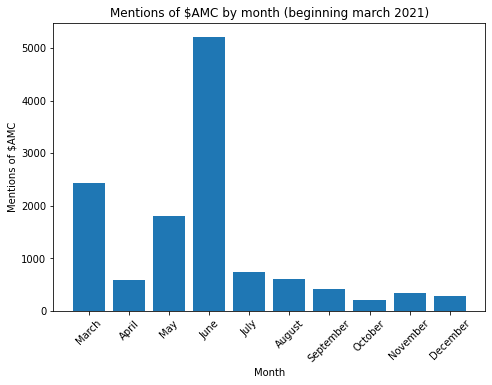

In [114]:
# Let's now take a look at mentions of AMC by month from March 2021 to Dec 2021
amc_mentions = []

amc = df_top_N.loc[df_top_N['symbol'] == 'AMC']
for month in months.values():
    amc_mentions.append(len(amc.loc[df_top_N['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
amc_mentions = amc_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], amc_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $AMC")
plt.title('Mentions of $AMC by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.savefig('fig/wsb-AMC-mentions.png')
plt.show()

# Section 2: Collecting Historic (Unadjusted) Stock Data with Alpha Vantage

In [11]:
%%time

# Sum all data by month and create our complete dataframe
top_N, df_N = get_top_N_stocks(df, N=200)
wsb_data = get_stock_pcts_and_mentions(top_N, df_N)

PINS
ABNB
HYLN
PLBY
AGC recently had their IPO. Skipping.
GOLD
BNTX
CGC
LIVE
TWO
ATVI
TDA
ASTR
NYC
GGPI
FCEL
GOOGL
KOSS
ZIM
IVR
TSM
RC
CTO
CPNG
BLNK
DOCU
IBKR
CVS
DCF
SE
DIDI
JD
SHOP
ID
LMND
HIMX
ROKU
SA
CHWY
ZM
NET
SRNE
MSM
CC
LNG
PUBM
BGFV
CHPT
CBD
DISCA
BOOM
CAR
GAIN
BARK
CCJ
INTC
AG
HUT
API
CTRM
XELA recently had their IPO. Skipping.
AFRM
CLVS
VS
BA
BP
AAL
COO
IRS
RKLB
PYPL
PSA
NFLX
GAME
MU
IBM
CCL
MC
NEGG
PHUN
LIFE
ATER
NNDM
CEI
MMAT
EDIT
IDEX
AR
PENN
ZOM
XL
POST
UPS
GSAT
EVER
BYND
IQ
TTCF
GEO
GDP
GNUS
RUN
TTM
BEST
FCF
DIS
NVAX
JPM
SNAP
SQ
FSR
F
ACB
WELL
PROG
BODY
WOOF
OPEN
PLUG
AN
ASTS
FREE
MVST
UPST
TELL
DM
WEN
MA
IP
PTON
FUBO
GE
MARA
SPRT
QS
BNGO
BBIG
INO
PSFE
SP
MRNA
NKLA
JP
SENS
PFE
SAVA
OI
SKLZ
MSFT
OG
RIOT
BBBY
MNMD
NAKD recently had their IPO. Skipping.
OCGN
COIN
HOOD
FB
IRNT
ROOT
SOS
ASO
GOEV
DKNG
GM
VIAC
TD
LCID
CRSR
AMZN
NVDA
RIDE
SOFI
RBLX
AAPL
CLF
NIO
BABA
SDC
NOK
MVIS
TLRY
RH
UP
SPCE
AMD
RKT
SNDL
UWMC
CLNE
WKHS
YOU
PLTR
IS
TSLA
WISH
CLOV
BB
AMC
GME
CPU times: user 1m

# Section 3: Putting it all together and cleaning data

In [13]:
column_names = ['symbol', 
                'month', 
                'month_idx', 
                'num_mentions_title', 
                'num_mentions_body', 
                'num_unique_symbols_title', 
                'num_unique_symbols_body', 
                'length_title', 
                'length_body']

aggregate_df = pd.DataFrame(columns = column_names)

for symbol in wsb_data.keys():
    for month in list(months.keys())[2:]:
        # r/WallStreetBets post data
        series = df_N[(df_N.symbol == symbol) & (df_N.month == months[month])].sum(axis='rows', numeric_only=True)[1:]
        series = pd.Series([symbol, month, months[month]], ['symbol', 'month', 'month_idx']).append(series)
        
        # r/WallStreetBets mentions
        series = pd.Series([wsb_data[symbol]['mentions'][months[month]-1]], ['num_unique_posts']).append(series)
        
        # Percent increase/decrease of the monthly stock price since the previous month
        series = pd.Series([wsb_data[symbol]['pcts'][months[month]-1]], ['next_month_price_pct_change']).append(series)

        aggregate_df = aggregate_df.append(series, ignore_index=True)

In [14]:
aggregate_df.head()
# aggregate_df.to_csv('csv/aggregate_data.csv')

,symbol,month,month_idx,num_mentions_title,num_mentions_body,num_unique_symbols_title,num_unique_symbols_body,length_title,length_body,next_month_price_pct_change,num_unique_posts
0,PINS,March,3,2,6,4,41,334,17173,8.573257,6.0
1,PINS,April,4,4,11,15,138,702,18978,-22.128603,11.0
2,PINS,May,5,4,11,5,115,624,22770,16.575502,12.0
3,PINS,June,6,8,3,8,2,322,1706,4.808189,8.0
4,PINS,July,7,4,7,11,26,293,7972,-23.128942,6.0


# Section 4: Setting up the machine learning and proof-of-concept

In [79]:
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], p
    
def pre_process(_X, _y, train_max=None):
    if not train_max:
        train_max = _X.max
    
    # Normalize the features of X
    X = _X / train_max(axis=0)
    
    # Convert stock percent increases (y) to binary "increased or did not increase"
    y = np.where(_y > 0, 1, -1).astype('int')

    return X, y

def tune(_X, _y, model, hyper_params):
    '''
    _X: numpy features from dataframe
    _y: numpy lables from dataframe
    model: sklearn model
    hyper_params: dict of lists of learning_ratess, n_estimators, max_depth, and n_features
    '''
    
    X, y = pre_process(_X, _y)
    
    X_train, y_train, p = unison_shuffled_copies(X[:train_ratio], y[:train_ratio])
    X_test, y_test, _ = unison_shuffled_copies(X[train_ratio:], y[train_ratio:])
    
    peak_acc = 0.0
    clfs = {}

    for lr in hyper_params['learning_rates']:
        for n_est in hyper_params['estimators']:
            for depth in hyper_params['depths']:
                for n_feat in hyper_params['features']:
                    
                    clf = None

                    if model == 'gb':
                        config = f'{model}_{lr}_{n_est}_{depth}_{n_feat}'
                        clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_est, max_depth=depth)
                    elif model == 'rf':
                        if lr != learning_rates[0]: # RandomForestClassifier has no learning rate, skip the loop
                            continue

                        config = f'{model}_{n_est}_{depth}_{n_feat}'
                        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth)

                    clf.fit(X_train, y_train)

                    y_pred = clf.predict(X_test)
#                     score = accuracy_score(y_test, y_pred)
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
                    score = auc(false_positive_rate, true_positive_rate)

                    clfs[config] = {}
                    clfs[config]['clf'] = clf
                    clfs[config]['preds'] = y_pred
                    clfs[config]['acc'] = score

                    if score > peak_acc:
                        peak_acc = score
                        print(f'{config}, auc: {score} (new peak accuracy)')
                    else:
                        print(f'{config}, auc: {score}')

    return clfs, peak_acc

In [133]:
train_ratio = round(0.75 * aggregate_df.shape[0])

_X = aggregate_df.drop(columns=['symbol', 'month', 'month_idx', 'next_month_price_pct_change']).to_numpy()
_y = aggregate_df['next_month_price_pct_change'].to_numpy()

n_features = _X.shape[1]

learning_rates = [0.1, 0.001, 0.0001]
estimators = [100, 1000, 10000]
depths = [3, 4, 5]
features = range(3, n_features+1)

hyper_params = {
    'learning_rates': learning_rates, 
    'estimators': estimators, 
    'depths': depths, 
    'features': features
}

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes

X_train_demo = X[:train_ratio]
y_train_demo = y[:train_ratio]

X_test_demo = X[train_ratio:]
y_test_demo = y[train_ratio:]

clf = GradientBoostingClassifier(learning_rate=0.0001, n_estimators=10000, max_depth=4)
clf.fit(X_train_demo, y_train_demo)


train_pred = clf.predict(X_train_demo)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_demo, train_pred)
print(f'Train AUC: {auc(false_positive_rate, true_positive_rate)}')
      
y_pred_demo = clf.predict(X_test_demo)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_demo, y_pred_demo)
print(f'Test AUC: {auc(false_positive_rate, true_positive_rate)}')

Train AUC: 0.513355592654424
Test AUC: 0.4996242753882487


In [134]:
X_train, y_train, _ = unison_shuffled_copies(X[:train_ratio], y[:train_ratio])
X_test, y_test, _ = unison_shuffled_copies(X[train_ratio:], y[train_ratio:])

# Section 5: Hyper Parameter Analysis

## Section 5a: Tuning Parameters Collectively

In [19]:
%%time

clf_collection = []
peak_acc_collection = []

for model in ['gb', 'rf']:
    # Indexing after the first 20 elements here means omitting the outlier stocks GME and AMC for training
    # (There are 10 months of data for each stock, and each row in the array is one month of data)
    clfs, accs = tune(_X=_X[20:], _y=_y[20:], model=model, hyper_params=hyper_params)
    clf_collection.append(clfs)
    peak_acc_collection.append(accs)

gb_0.1_100_3_3, auc: 0.508235544299882 (new peak accuracy)
gb_0.1_100_3_4, auc: 0.5003286484814508
gb_0.1_100_3_5, auc: 0.5036731300868019
gb_0.1_100_3_6, auc: 0.508235544299882
gb_0.1_100_3_7, auc: 0.5020008892841263
gb_0.1_100_4_3, auc: 0.5074912521507142
gb_0.1_100_4_4, auc: 0.5120536663637945 (new peak accuracy)
gb_0.1_100_4_5, auc: 0.5062733195429853
gb_0.1_100_4_6, auc: 0.5053647031530922
gb_0.1_100_4_7, auc: 0.5062733195429853
gb_0.1_100_5_3, auc: 0.5078005683685503
gb_0.1_100_5_4, auc: 0.5032381541554701
gb_0.1_100_5_5, auc: 0.5065826357608212
gb_0.1_100_5_6, auc: 0.5106907417789549
gb_0.1_100_5_7, auc: 0.5044560867631991
gb_0.1_1000_3_3, auc: 0.4941326579929244
gb_0.1_1000_3_4, auc: 0.4941326579929244
gb_0.1_1000_3_5, auc: 0.49702283140332904
gb_0.1_1000_3_6, auc: 0.4895702437798442
gb_0.1_1000_3_7, auc: 0.49124248458251984
gb_0.1_1000_4_3, auc: 0.48500782956676397
gb_0.1_1000_4_4, auc: 0.4883523111721152
gb_0.1_1000_4_5, auc: 0.4883523111721152
gb_0.1_1000_4_6, auc: 0.4866800

## Section 5b: Tuning Parameters Independently

Parameters to be analyzed as outlined by Mohtadi Ben Fraj:
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

### Learning Rate

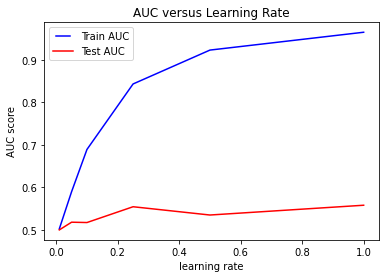

In [108]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for eta in learning_rates:
    clf = GradientBoostingClassifier(learning_rate=eta)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus Learning Rate')
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.savefig('fig/AUC-versus-Learning-Rate.png')
plt.show()

### N_estimators

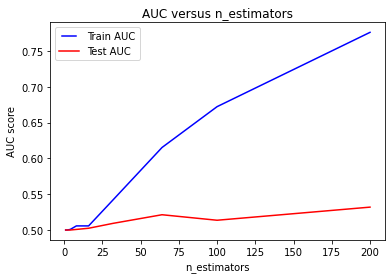

In [109]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for estimator in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=estimator)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus n_estimators')
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.savefig('fig/AUC-versus-n_estimators.png')
plt.show()

### max_depth

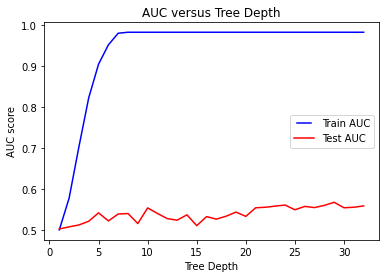

In [110]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for max_depth in max_depths:
    clf = GradientBoostingClassifier(max_depth=max_depth)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus Tree Depth')
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.savefig('fig/AUC-versus-tree-depth.png')
plt.show()

### min_samples_split

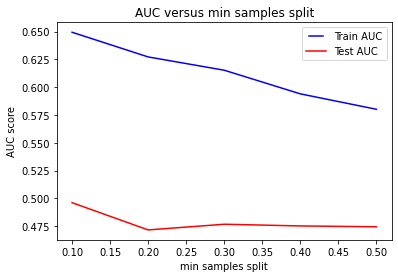

In [111]:
min_samples_splits = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for min_samples_split in min_samples_splits:
    clf = GradientBoostingClassifier(min_samples_split=min_samples_split)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus min samples split')
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.savefig('fig/AUC-versus-min-samples-split.png')
plt.show()

### min_samples_leaf

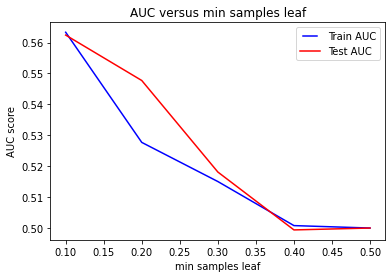

In [113]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for min_samples_leaf in min_samples_leafs:
    clf = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus min samples leaf')
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.savefig('fig/AUC-versus-min-samples-leaf.png')
plt.show()

### max_features

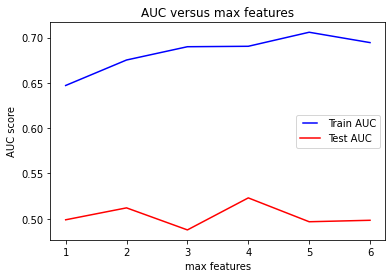

In [149]:
max_features = list(range(1,_X.shape[1]))

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for max_feature in max_features:
    clf = GradientBoostingClassifier(max_features=max_feature)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus max features')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.savefig('fig/AUC-versus-max-features.png')
plt.show()

In [44]:
aggregate_df[:-20]

,symbol,month,month_idx,num_mentions_title,num_mentions_body,num_unique_symbols_title,num_unique_symbols_body,length_title,length_body,next_month_price_pct_change,num_unique_posts
0,PINS,March,3,2,6,4,41,334,17173,8.573257,6.0
1,PINS,April,4,4,11,15,138,702,18978,-22.128603,11.0
2,PINS,May,5,4,11,5,115,624,22770,16.575502,12.0
3,PINS,June,6,8,3,8,2,322,1706,4.808189,8.0
4,PINS,July,7,4,7,11,26,293,7972,-23.128942,6.0
...,...,...,...,...,...,...,...,...,...,...,...
1945,BB,August,8,68,110,133,189,5174,92596,0.026387,92.0
1946,BB,September,9,79,78,116,176,6512,119839,-0.630092,103.0
1947,BB,October,10,62,95,74,101,4559,53715,4.286052,77.0
1948,BB,November,11,80,84,94,149,5719,83109,-14.970664,108.0


In [157]:
X, y = pre_process(_X[20:], _y[20:]) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_seed)

clf = GradientBoostingClassifier(learning_rate=0.5, 
                                 n_estimators=200, 
                                 max_depth=3, 
                                 min_samples_split=0.1, 
                                 min_samples_leaf=0.2, 
                                 max_features=6)

clf.fit(x_train, y_train)

train_pred = clf.predict(x_train)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'Train AUC: {roc_auc}')

y_pred = clf.predict(x_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'Test AUC: {roc_auc}')


Train AUC: 0.647909558084076
Test AUC: 0.5176788542312194


In [122]:
_aggregate_df = aggregate_df
_aggregate_df['next_month_price_pct_change'] = np.where(aggregate_df['next_month_price_pct_change'] > 0, 1, -1).astype('int')

In [135]:
peak_acc_collection

[0.5240686682003595, 0.5]